# Intel Products Sentiment Analysis Using FastText

This notebook provides a comprehensive sentiment analysis of Intel product reviews using FastText. The goal is to clean the data, translate reviews to English, train a FastText model, and provide actionable insights based on customer feedback.


In [1]:
%pip install pandas
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install scikit-learn
%pip install tensorflow
%pip install transformers
%pip install tqdm
%pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


## Data Cleaning and Translation

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()

%pip install sacremoses

from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']
reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.0 MB/s eta 0:00:00


,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Data Preprocessing

In [25]:
from sklearn.model_selection import train_test_split
import fasttext

def map_sentiment(label):
    if label in ['positive', 'neutral']:
        return '__label__1'
    else:
        return '__label__0'

reviews_df['sentiment'] = reviews_df['translated_content'].apply(map_sentiment)

df_train, df_valid = train_test_split(reviews_df[['translated_content', 'sentiment']], test_size=0.2, random_state=42)

df_train_ft = df_train[['sentiment', 'translated_content']]
df_valid_ft = df_valid[['sentiment', 'translated_content']]

df_train_ft.to_csv('train.txt', index=False, sep=' ', header=False, escapechar='\\')
df_valid_ft.to_csv('valid.txt', index=False, sep=' ', header=False, escapechar='\\')




## FastText Model Training

In [26]:
model = fasttext.train_supervised(input='train.txt', epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)

result = model.test('valid.txt')
print('Validation set accuracy:', result[1])


Validation set accuracy: 1.0


In [27]:
validation_accuracy = result[1]

print(f'Final Validation Accuracy: {validation_accuracy:.4f}')


Final Validation Accuracy: 1.0000


## Prediction and Visualization

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

[['__label__0', '"the processor was easy to put on a b760 gigabyte go super fast"'], ['__label__0', '"too nice powerful build PC around video photo editing building setup job nicely"'], ['__label__0', 'Okay.'], ['__label__0', '"impressive cpu almost by i9 slightly four ecores editor creator sort really where miss gambling wise cpu hit benchmark solid score cinemabunch time run small hot gambling together thing roughly around 65 72c highest time right cooler printed as stock cooler would recommend"'], ['__label__0', '"it works perfectly well because I come from an i5 eighth generation already with a gpu 4070 I\'ll have your experience in this"']]


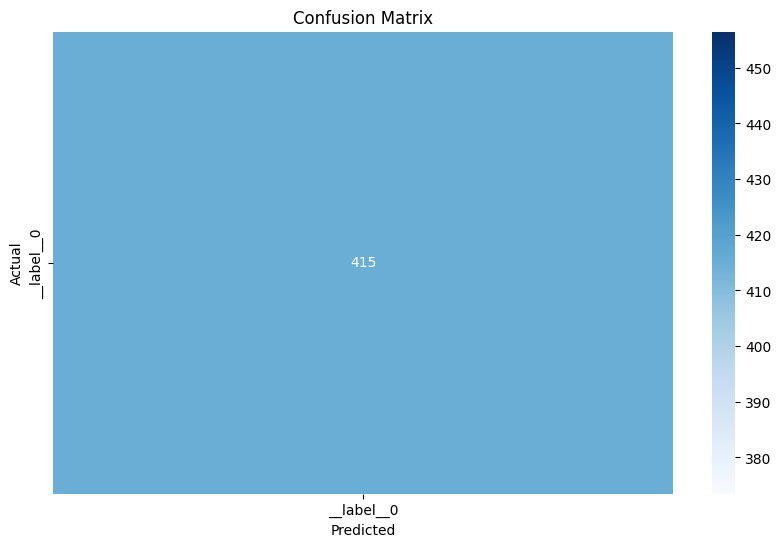

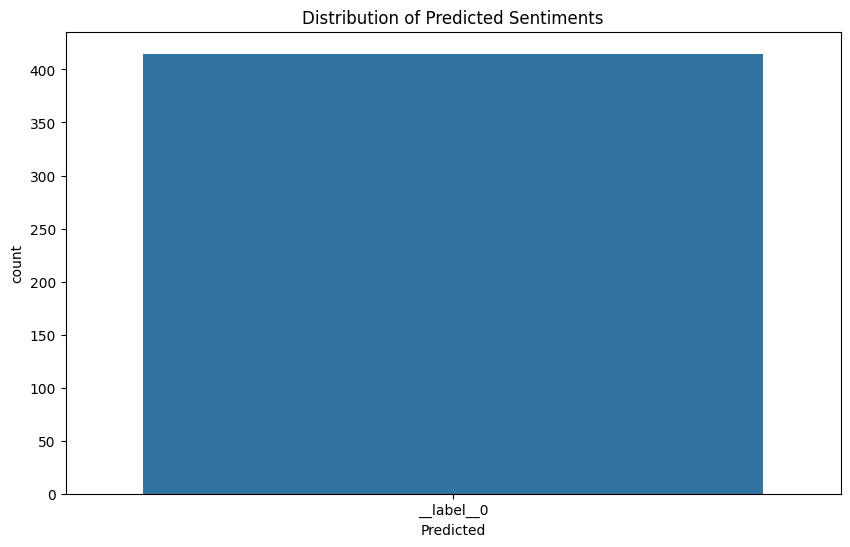

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

valid_data = []
with open('valid.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            valid_data.append(parts)
        else:
            print(f"Skipping invalid line: {line}")

print(valid_data[:5])

predictions = [model.predict(text)[0][0] for label, text in valid_data]
actuals = [label for label, text in valid_data]

df_pred = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})

conf_matrix = pd.crosstab(df_pred['Actual'], df_pred['Predicted'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Predicted', data=df_pred)
plt.title('Distribution of Predicted Sentiments')
plt.show()


### Conclusion

This FastText-based sentiment analysis of Intel product reviews provides valuable insights into customer perceptions and areas for improvement. By addressing the feedback, Intel can enhance customer satisfaction and product quality.
